In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
from scipy.spatial.distance import cdist

import os

In [15]:
def name_dataset(df, name, embedding_type = None, esm_type = None):
    df['dataset'] = name
    if embedding_type is not None:
        df['embedding_type'] = embedding_type
    if esm_type is not None:
        df['esm_type'] = esm_type
    return df

def read_data_feature_importance(experiment, round_num=10, esm="esm2", size_csvs = "t48_15B_UR50D"):
    csvs_file_names_list = ["cov2_S", "cas12f", "zikv_E", "kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]

    all_dfs = []

    for file_name in csvs_file_names_list:
        # Attempt to read the file, and if it doesn't exist, skip to the next iteration
        try:
            if size_csvs != "":
                file_path = f"../../grid_search/results/{file_name}_{esm}_{size_csvs}_{experiment}_results.csv"
                individual_df = pd.read_csv(file_path)
            elif size_csvs == "":
                file_path = f"../../grid_search/results/{file_name}_{esm}_{experiment}_results.csv"
                individual_df = pd.read_csv(file_path)                

            # Filter the DataFrame based on the round_num column
            individual_df = individual_df[individual_df['round_num'] == round_num]
            
            # Add dataset information
            individual_df = name_dataset(individual_df, file_name)

            # Append to list of individual DataFrames
            all_dfs.append(individual_df)
        except FileNotFoundError:
            print(f"File {file_name}_{esm}_{size_csvs}_{experiment}_results.csv not found. Skipping...")

    # Concatenate all individual DataFrames
    df = pd.concat(all_dfs)

    return df

In [16]:
# Function to read in the data
def read_data(dataset_name, base_path, file_type, first_round_strategies, embeddings_type='both'):
    # Construct the file paths
    if file_type == "csvs":
        split_name = dataset_name.split('_')
        if len(split_name[1]) == 1:
            dataset_name_label = split_name[0] + '_' + split_name[1]
        else:
            dataset_name_label = split_name[0]
        labels_file = os.path.join(base_path, 'labels', dataset_name_label + '_labels.csv')
        hie_file = os.path.join(base_path, 'hie_temp', dataset_name_label + '.csv')
        embeddings_file = os.path.join(base_path, 'csvs', dataset_name + '.csv')
        # Read in mean embeddings across all rounds
        embeddings = pd.read_csv(embeddings_file, index_col=0)
    elif file_type == "pts":
        labels_file = os.path.join(base_path, 'labels', dataset_name.split('_')[-1] + '_labels.csv')
        hie_file = os.path.join(base_path, 'hie_temp', dataset_name.split('_')[-1] + '.csv')
        embeddings_file = os.path.join(base_path, 'pts', dataset_name + '.pt')
        # Read in pytorch tensor of embeddings
        embeddings = torch.load(embeddings_file)
        # Convert embeddings to a dataframe
        if embeddings_type == 'average':
            embeddings = {key: value['average'].numpy() for key, value in embeddings.items()}
        elif embeddings_type == 'mutated':
            embeddings = {key: value['mutated'].numpy() for key, value in embeddings.items()}
        elif embeddings_type == 'both':
            embeddings = {key: torch.cat((value['average'], value['mutated'])).numpy() for key, value in embeddings.items()}
        else:
            print("Invalid embeddings_type. Please choose 'average', 'mutated', or 'both'")
            return None, None

        # Convert embeddings dictionary to a dataframe
        embeddings = pd.DataFrame.from_dict(embeddings, orient='index')
    else:
        print("Invalid file type. Please choose either 'csvs' or 'pts'")
        return None, None

    # Read in labels
    labels = pd.read_csv(labels_file)

    # Read in hie
    if first_round_strategies == "representative_hie":
        hie_data = pd.read_csv(hie_file)
    else:
        hie_data = pd.DataFrame()

    # Filter out rows where fitness is NaN
    labels = labels[labels['fitness'].notna()]

    # Filter out rows in embeddings where row names are not in labels variant column
    embeddings = embeddings[embeddings.index.isin(labels['variant'])]

    # Align labels by variant
    labels = labels.sort_values(by=['variant'])

    # Align embeddings by row name
    embeddings = embeddings.sort_index()

    # Confirm that labels and embeddings are aligned, reset index
    labels = labels.reset_index(drop=True)

    # Get the variants in labels and embeddings, convert to list
    label_variants = labels['variant'].tolist()
    embedding_variants = embeddings.index.tolist()

    # Check if embedding row names and label variants are identical
    if label_variants == embedding_variants:
        print('Embeddings and labels are aligned')

    # return embeddings and labels
    return embeddings, labels, hie_data

In [50]:
def get_feature_importances(model, regression_type):
    if regression_type in ['ridge', 'lasso', 'elasticnet', 'linear']:
        return model.coef_
    elif regression_type == 'randomforest':
        return model.feature_importances_
    elif regression_type == 'gradientboosting':
        return model.feature_importances_
    elif regression_type == 'neuralnet':
        return model.coefs_[0]  # For MLP, we get the first layer weights
    else:
        raise ValueError(f"Unknown regression type: {regression_type}")

def top_layer_feature_importances(embeddings_pd, labels_pd, measured_var, this_round_variants, regression_type='ridge'):
    # Filter the embeddings and labels based on this_round_variants
    filtered_embeddings = embeddings_pd[embeddings_pd.index.isin(this_round_variants)]
    filtered_labels = labels_pd[labels_pd['variant'].isin(this_round_variants)]

    # Check if we have matching rows after filtering
    if len(filtered_embeddings) != len(filtered_labels):
        raise ValueError("Mismatch between number of embeddings and labels after filtering for this_round_variants.")

    # Prepare the training data
    X_train = filtered_embeddings
    y_train = filtered_labels[measured_var]

    # Initialize the regression model
    if regression_type == 'ridge':
        model = RidgeCV()
    elif regression_type == 'lasso':
        model = LassoCV(max_iter=100000, tol=1e-3)
    elif regression_type == 'elasticnet':
        model = ElasticNetCV(max_iter=100000, tol=1e-3)
    elif regression_type == 'linear':
        model = LinearRegression()
    elif regression_type == 'neuralnet':
        model = MLPRegressor(hidden_layer_sizes=(5), max_iter=1000, activation='relu', solver='adam', alpha=0.001,
                             learning_rate='constant', learning_rate_init=0.001, random_state=1, tol=0.0001)
    elif regression_type == 'randomforest':
        model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', random_state=1)
    elif regression_type == 'gradientboosting':
        model = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                     max_depth=5, alpha=10, n_estimators=10)
    else:
        raise ValueError(f"Unknown regression type: {regression_type}")

    # Fit the model
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = get_feature_importances(model, regression_type)

    # Return the feature importances
    return feature_importances

# Function to compute average feature importances across datasets
def average_feature_importances(datasets_df, embeddings, labels, measured_var, regression_type='ridge'):
    all_feature_importances = []
    for _, row in datasets_df.iterrows():
        this_round_variants = row['this_round_variants'].split(',')
        feature_importances = top_layer_feature_importances(embeddings, labels, measured_var, this_round_variants, regression_type)
        all_feature_importances.append(feature_importances)

    # Compute the average feature importances
    avg_feature_importances = np.mean(all_feature_importances, axis=0)
    return avg_feature_importances

def plot_feature_importances(feature_importances, dataset_name, feature_names=None, top_n=None, output_dir='results/feature_importance'):
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

    # Sort the feature importances and corresponding feature names
    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = np.array(feature_names)[sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    # If top_n is specified, select only the top_n features for plotting
    if top_n is not None:
        sorted_features = sorted_features[:top_n]
        sorted_importances = sorted_importances[:top_n]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_features)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importances for {dataset_name}')
    plt.gca().invert_yaxis()
    plt.show()

    # Save all feature importances to CSV
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f'{dataset_name}_feature_importances_round_10.csv')
    
    # Create a DataFrame and save to CSV
    feature_importance_df = pd.DataFrame({
        'Feature': np.array(feature_names)[sorted_idx],
        'Importance': feature_importances[sorted_idx]
    })
    feature_importance_df.to_csv(output_path, index=False)

def analyze_dataset(dataset_name, result_df_15B, base_path, file_type='csvs', embeddings_type='average', measured_var='fitness', regression_type='ridge'):
    # Read embeddings and labels
    embeddings, labels, hie_data = read_data(dataset_name, base_path, file_type, embeddings_type)
    
    # Subset results to 15B
    dataset_data = result_df_15B[result_df_15B['dataset'] == dataset_name.split('_')[0]]
    
    # Compute average feature importances
    avg_feature_importances = average_feature_importances(dataset_data, embeddings, labels, measured_var, regression_type)
    
    # Plot the feature importances
    plot_feature_importances(avg_feature_importances, dataset_name, top_n=20)
    
    # Clear variables to save memory
    del embeddings, labels, hie_data

In [48]:
# Get final round for each dataset:
experiment = "esm2_15B_average"
round_num = 10
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_15B = read_data_feature_importance(experiment, round_num, esm, size_csvs)
result_df_15B['label'] = "esm2 15B"

Embeddings and labels are aligned


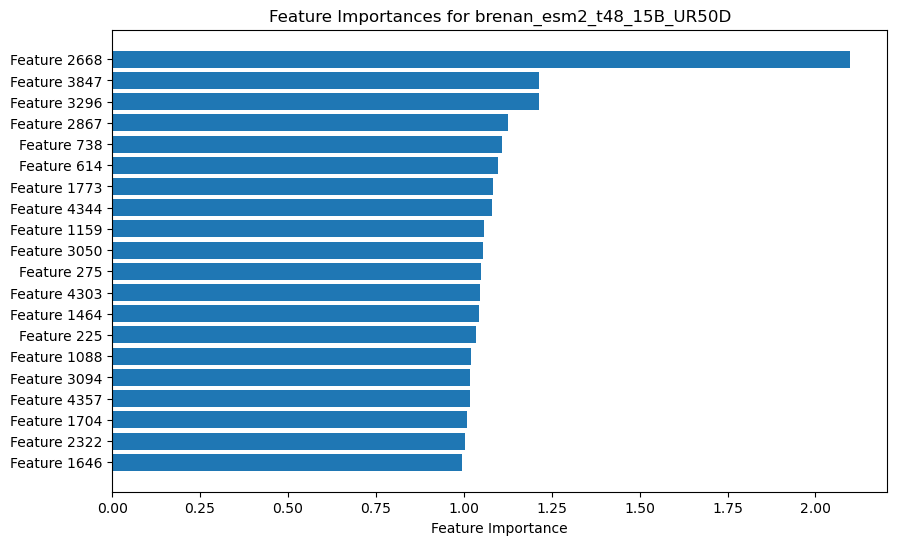

Embeddings and labels are aligned


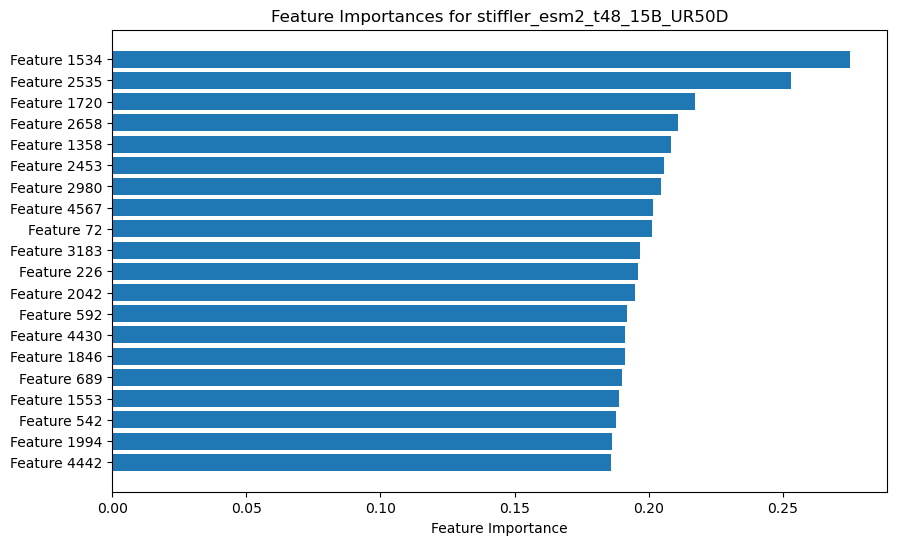

Embeddings and labels are aligned


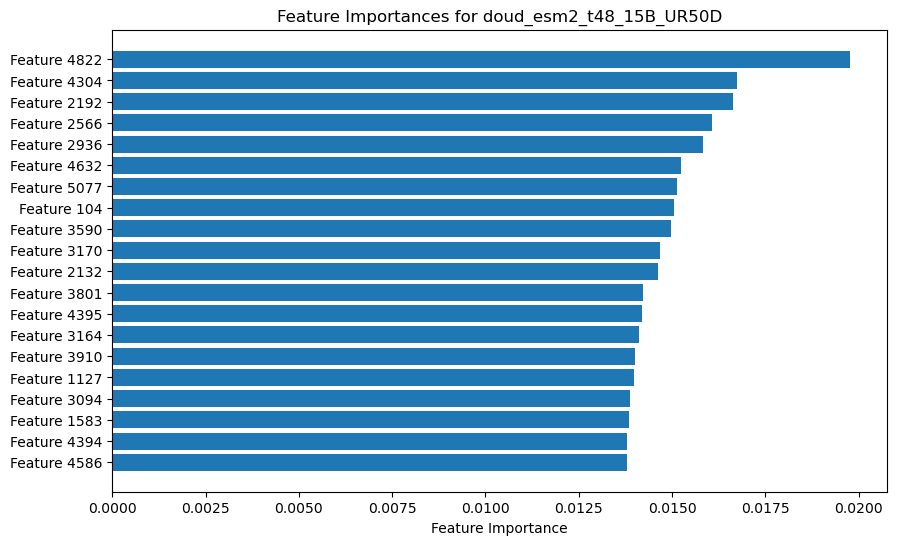

Embeddings and labels are aligned


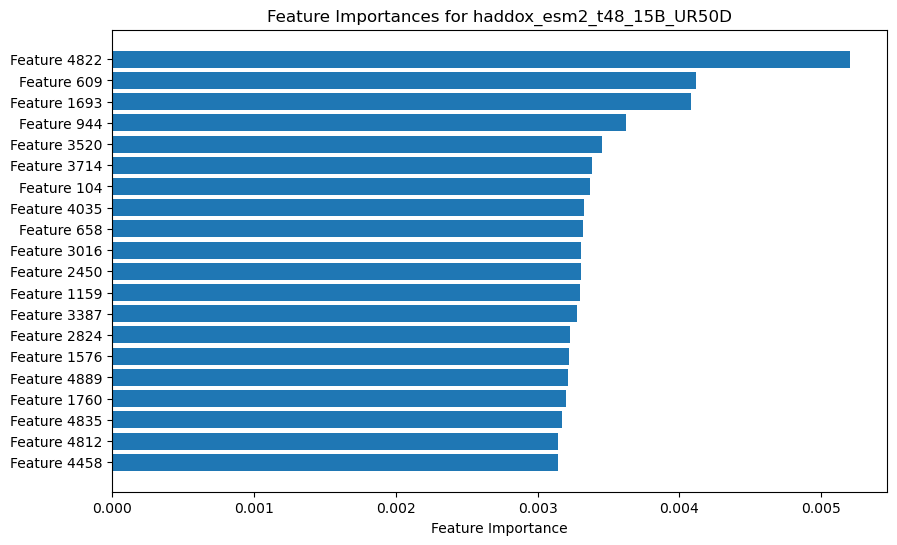

Embeddings and labels are aligned


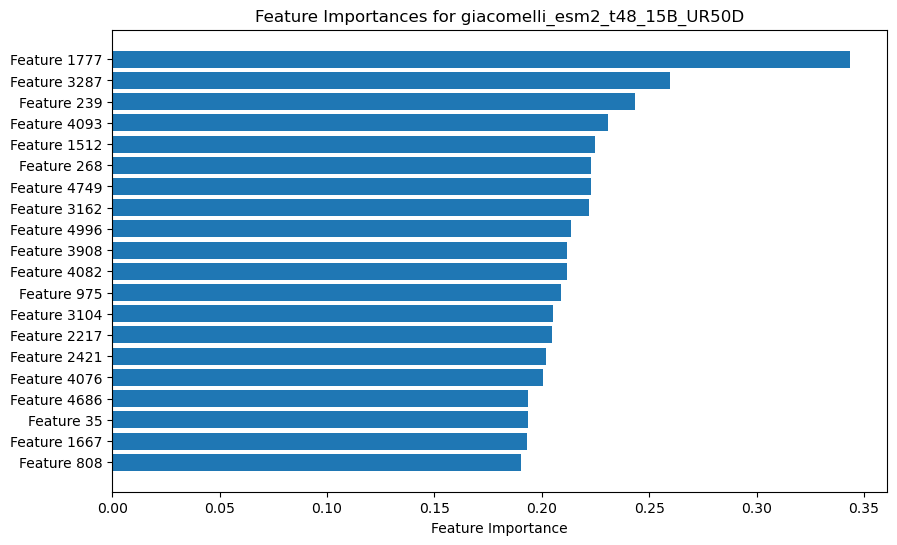

Embeddings and labels are aligned


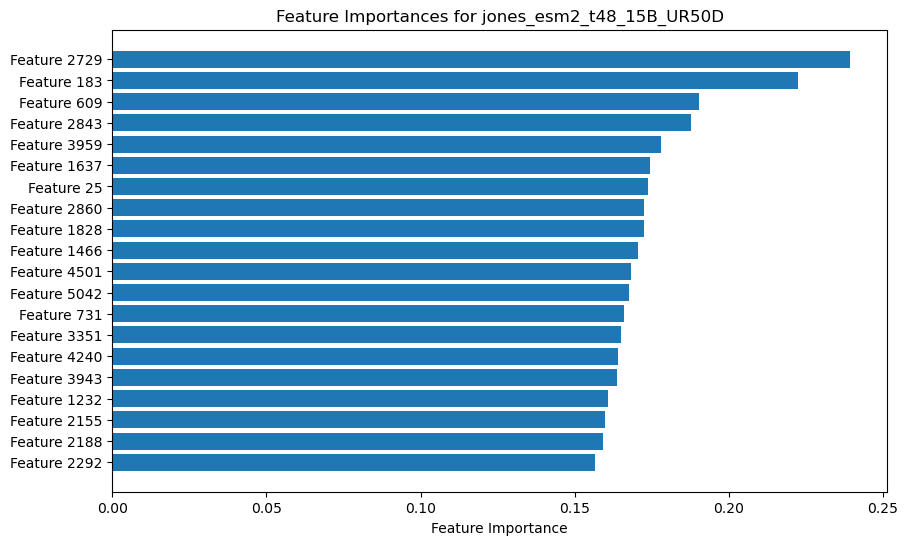

Embeddings and labels are aligned


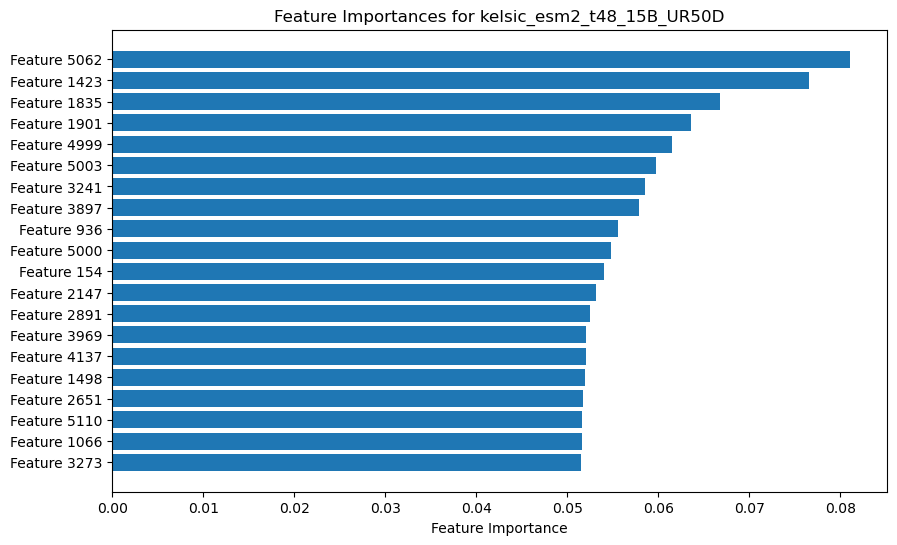

Embeddings and labels are aligned


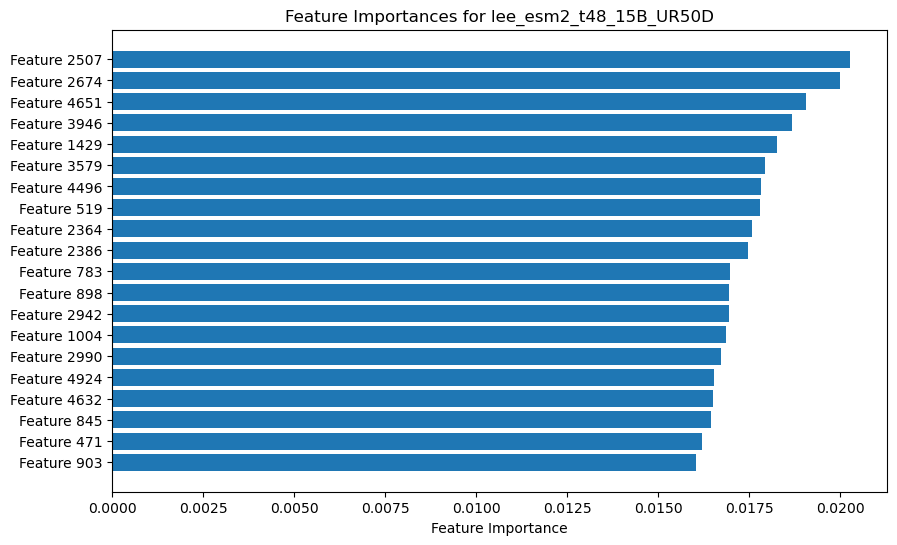

Embeddings and labels are aligned


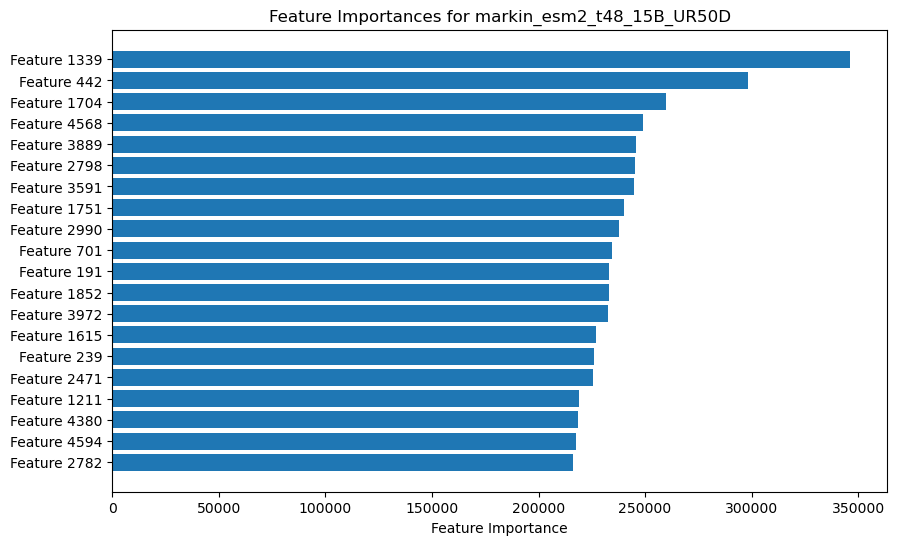

Embeddings and labels are aligned


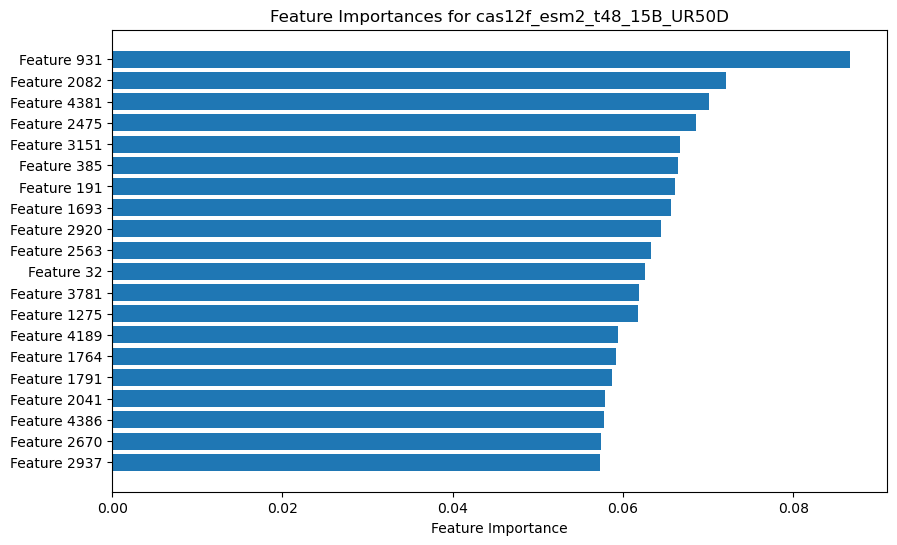

In [55]:
# List of dataset names
dataset_names = ["brenan", "stiffler", "doud", "haddox", "giacomelli", "jones", "kelsic", "lee", "markin", "cas12f"]

# Analyze each dataset
for dataset_name in dataset_names:
    full_dataset_name = f"{dataset_name}_esm2_t48_15B_UR50D"
    analyze_dataset(full_dataset_name, result_df_15B, base_path)

Embeddings and labels are aligned


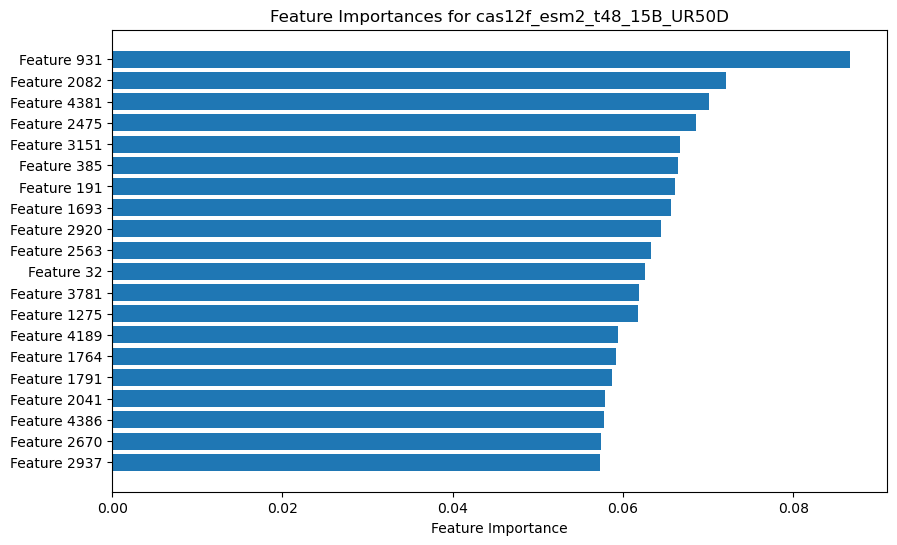

Embeddings and labels are aligned


/home/md3498/anaconda3/envs/embeddings/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/md3498/anaconda3/envs/embeddings/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

In [54]:
# List of dataset names
dataset_names = ["zikv_E", "cov2_S"]

# Analyze each dataset
for dataset_name in dataset_names:
    full_dataset_name = f"{dataset_name}_esm2_t48_15B_UR50D"
    analyze_dataset(full_dataset_name, result_df_15B, base_path)